## EDA Regresion Lineal

Voy a usar un modelo simple y explicable para ver cuánto influyen edad, BMI, hijos y hábitos de vida en el coste médico

Setup de librerias

In [153]:
import numpy as np
import pandas as pd
import json
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import warnings
from sklearn.exceptions import ConvergenceWarning

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

Carga del CVS

In [154]:
df = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=929&path=medical_insurance_cost.csv', sep=',') # Este archivo CSV contiene comas como separadores
print(df.head())
print(df.columns) 


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='str')


In [155]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   str    
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   str    
 5   region    1338 non-null   str    
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), str(3)
memory usage: 73.3 KB


### Resumen de cada columna:
age. Edad del beneficiario principal (numérico)
sex. Género del beneficiario principal (categórico)
bmi. índice de masa corporal (numérico)
children. Número de niños/dependientes cubiertos por un seguro médico (numérico)
smoker. ¿Es fumador? (categórico)
region. Área residencial del beneficiario en USA: noreste, sureste, suroeste, noroeste (categórico)
charges. Prima del seguro médico (numérico)

In [156]:
df.shape
print(f"Numero de columnas:{df.shape}")

Numero de columnas:(1338, 7)


Duplicates

In [157]:
df.duplicated().sum()
df= df.drop_duplicates()

Dropeo de columnas que no sirvan

In [158]:
#df=df.drop(columns=[none]) #no hay ninguna columna que deberia droppearse ya que todas aportan un valor


## Análisis de variables univariante

In [159]:

total_dataf = df

Empezamos por los valores numericos # age bmi children charges

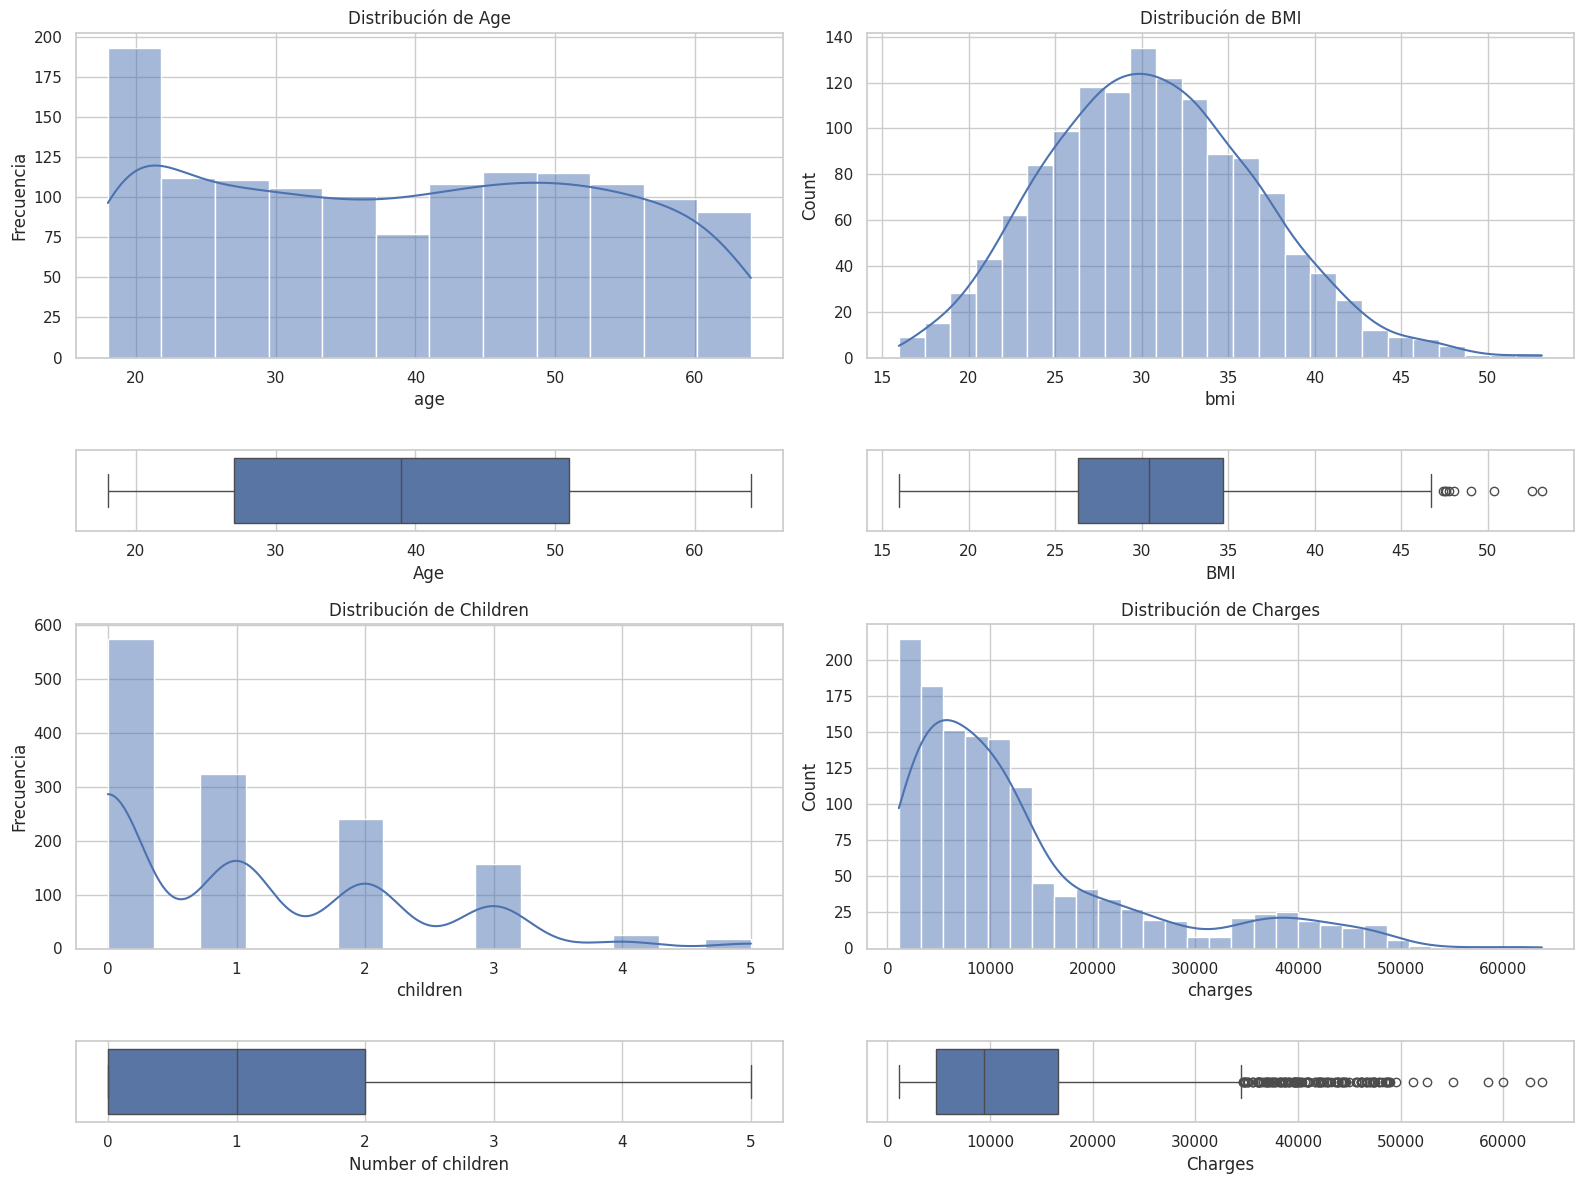

In [160]:
fig, axis = plt.subplots(
    4, 2,
    figsize=(16, 12),
    gridspec_kw={'height_ratios': [4, 1, 4, 1]}
)

# AGE
sns.histplot(data=total_dataf, x="age", ax=axis[0, 0], kde=True)
sns.boxplot(data=total_dataf, x="age", ax=axis[1, 0])

axis[0, 0].set_title("Distribución de Age")
axis[1, 0].set_xlabel("Age")
axis[0, 0].set_ylabel("Frecuencia")

# BMI
sns.histplot(data=total_dataf, x="bmi", ax=axis[0, 1], kde=True)
sns.boxplot(data=total_dataf, x="bmi", ax=axis[1, 1])

axis[0, 1].set_title("Distribución de BMI")
axis[1, 1].set_xlabel("BMI")

# CHILDREN
sns.histplot(data=total_dataf, x="children", ax=axis[2, 0], kde=True)
sns.boxplot(data=total_dataf, x="children", ax=axis[3, 0])

axis[2, 0].set_title("Distribución de Children")
axis[3, 0].set_xlabel("Number of children")
axis[2, 0].set_ylabel("Frecuencia")

# CHARGES
sns.histplot(data=total_dataf, x="charges", ax=axis[2, 1], kde=True)
sns.boxplot(data=total_dataf, x="charges", ax=axis[3, 1])

axis[2, 1].set_title("Distribución de Charges")
axis[3, 1].set_xlabel("Charges")

plt.tight_layout()
plt.show()


## Conclusión del análisis univariante de variables numéricas

El análisis univariante de las variables numéricas permite comprender la distribución, dispersión y presencia de valores atípicos en el conjunto de datos.

La variable age presenta una distribución relativamente uniforme a lo largo de su rango, sin asimetrías pronunciadas ni valores atípicos extremos. Esto sugiere que la edad está bien representada en el conjunto de datos y no requiere transformaciones especiales.

La variable bmi muestra una distribución aproximadamente normal, aunque con una ligera asimetría positiva. Se observan algunos valores atípicos en el extremo superior, lo cual es esperable al tratarse de una medida relacionada con el peso corporal. No obstante, la mayoría de los valores se concentran en un rango razonable.

En cuanto a children, se trata de una variable discreta con pocos valores posibles. La distribución está claramente sesgada hacia valores bajos, siendo los valores más frecuentes 0, 1 y 2 hijos. No se detectan valores anómalos relevantes.

Por último, charges presenta una distribución fuertemente asimétrica a la derecha, con una gran concentración de observaciones en valores bajos y la presencia de outliers significativos en el extremo superior. Esta característica sugiere que la variable objetivo podría beneficiarse de una transformación logarítmica para mejorar el ajuste del modelo de regresión.

En conjunto, el análisis univariante indica que las variables predictoras numéricas son consistentes y razonables, mientras que la variable objetivo muestra una alta variabilidad y asimetría, lo que debe tenerse en cuenta en la fase de modelado.

## Analisis Categorico (Smoker, Sex, Region)

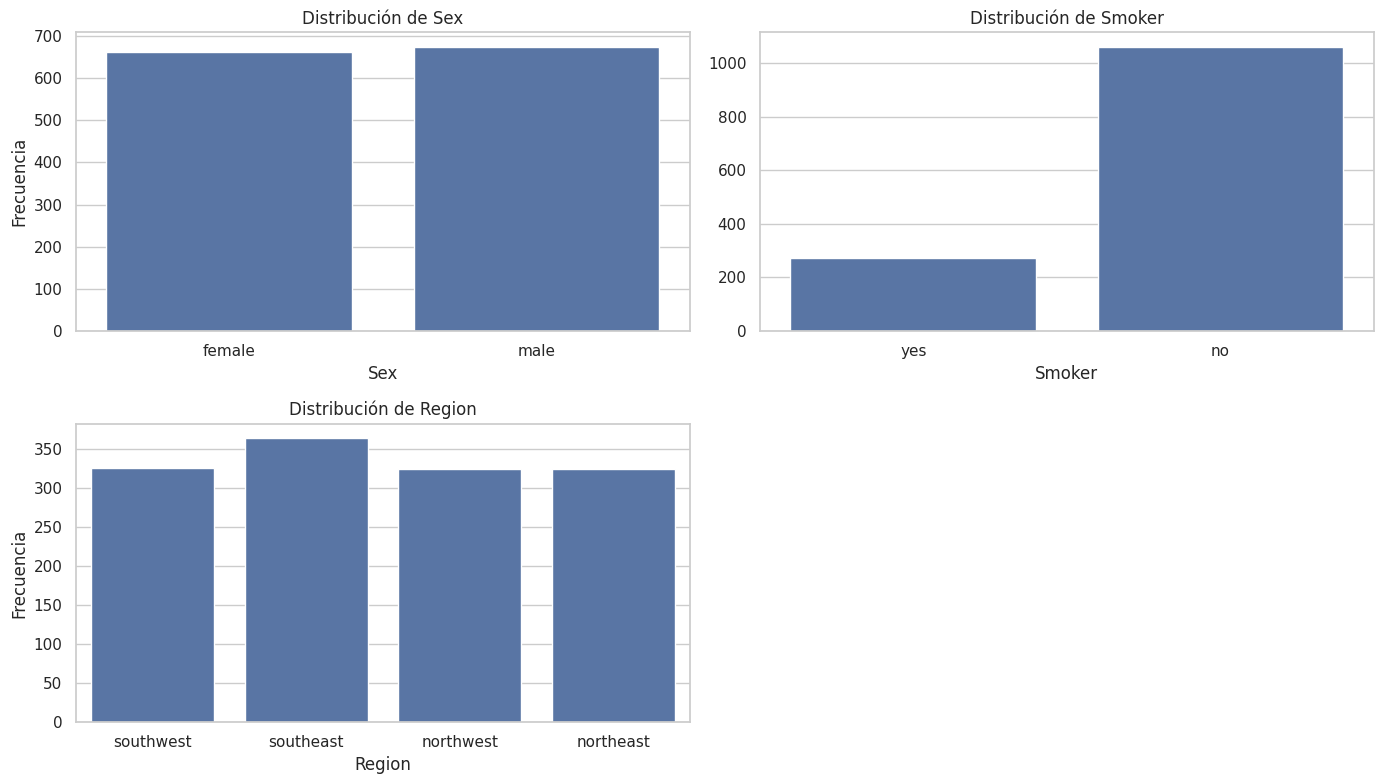

In [161]:
fig, axis = plt.subplots(2, 2, figsize=(14, 8))

# SEX
sns.countplot(data=total_dataf, x="sex", ax=axis[0, 0])
axis[0, 0].set_title("Distribución de Sex")
axis[0, 0].set_xlabel("Sex")
axis[0, 0].set_ylabel("Frecuencia")

# SMOKER
sns.countplot(data=total_dataf, x="smoker", ax=axis[0, 1])
axis[0, 1].set_title("Distribución de Smoker")
axis[0, 1].set_xlabel("Smoker")
axis[0, 1].set_ylabel("")

# REGION
sns.countplot(data=total_dataf, x="region", ax=axis[1, 0])
axis[1, 0].set_title("Distribución de Region")
axis[1, 0].set_xlabel("Region")
axis[1, 0].set_ylabel("Frecuencia")

# Eliminar subplot vacío
fig.delaxes(axis[1, 1])

plt.tight_layout()
plt.show()


El análisis univariante de las variables categóricas muestra una distribución equilibrada entre sexos, una menor proporción de fumadores frente a no fumadores y una distribución relativamente homogénea entre las distintas regiones, sin desequilibrios extremos que puedan afectar negativamente al modelado.

## Analisis Multivariante

Analisis numerico-numerico

Se eligió charges como variable objetivo porque representa el coste médico anual, una variable continua y de interés práctico, que puede ser razonablemente explicada a partir de características demográficas y de estilo de vida como la edad, el índice de masa corporal o el hábito de fumar.

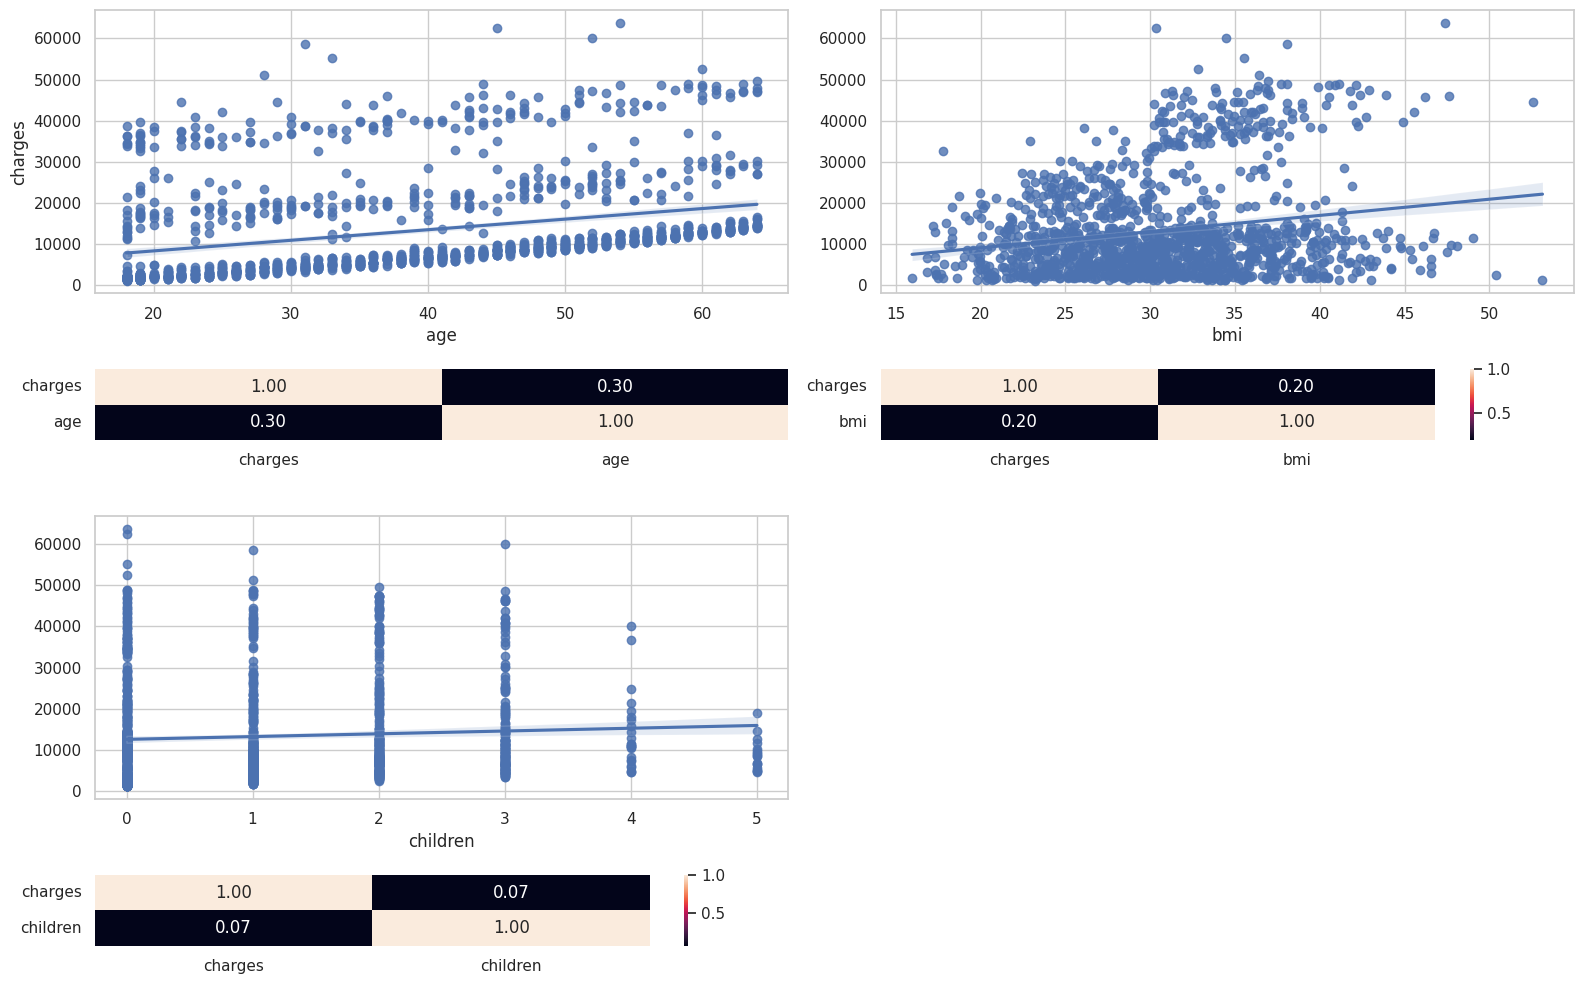

In [162]:
fig, axis = plt.subplots(4, 2, figsize = (16, 10), gridspec_kw={'height_ratios': [4, 1, 4, 1]})

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0, 0], data = total_dataf, x = "age", y = "charges")
sns.heatmap(total_dataf[["charges", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 0], cbar = False)

sns.regplot(ax = axis[0, 1], data = total_dataf, x = "bmi", y = "charges").set(ylabel=None)
sns.heatmap(total_dataf[["charges", "bmi"]].corr(), annot = True, fmt = ".2f", ax = axis[1, 1])

sns.regplot(ax = axis[2, 0], data = total_dataf, x = "children", y = "charges").set(ylabel=None)
sns.heatmap(total_dataf[["charges", "children"]].corr(), annot = True, fmt = ".2f", ax = axis[3, 0])


fig.delaxes(axis[2, 1])
fig.delaxes(axis[3, 1])

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()

El análisis bivariante confirma que el coste médico no depende de un único factor, sino de la combinación de múltiples variables, lo que justifica el uso de modelos de regresión multivariante para capturar estas relaciones de forma conjunta.

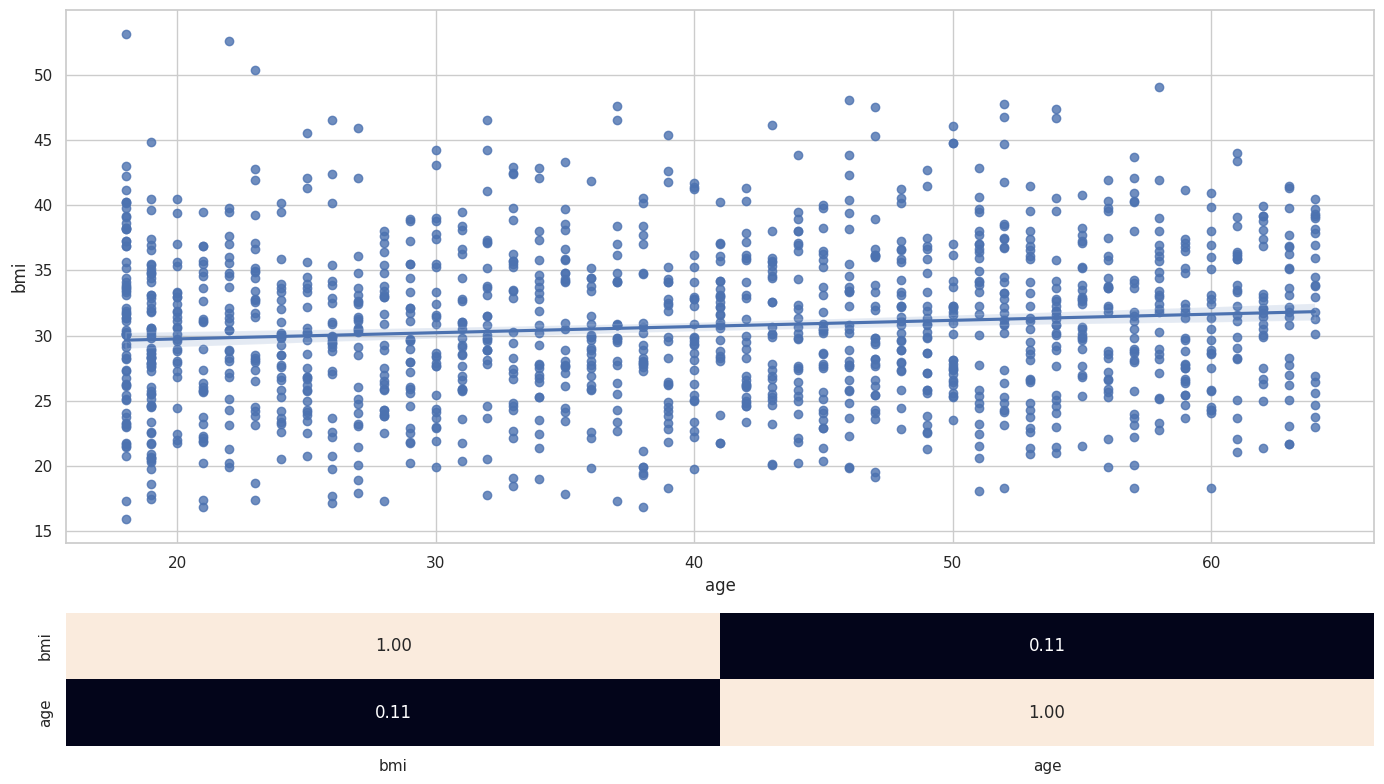

In [163]:
fig, axis = plt.subplots(2, 1, figsize = (14, 8), gridspec_kw={'height_ratios': [4, 1]})

# Crear un diagrama de dispersión múltiple
sns.regplot(ax = axis[0], data = total_dataf, x = "age", y = "bmi")
sns.heatmap(total_dataf[["bmi", "age"]].corr(), annot = True, fmt = ".2f", ax = axis[1], cbar = False)

# Ajustar el layout
plt.tight_layout()

# Mostrar el plot
plt.show()


Se analizó la relación entre las variables numéricas age y bmi con el objetivo de detectar posibles relaciones lineales entre predictores que pudieran indicar multicolinealidad. El diagrama de dispersión y el coeficiente de correlación muestran una relación débil entre ambas variables, lo que sugiere que aportan información complementaria al modelo de regresión.

Analisis categorico-categorico
¿El coste médico cambia según el sexo, y depende además de la edad?
¿El coste médico cambia por región? ¿Y qué pasa si además la persona fuma?

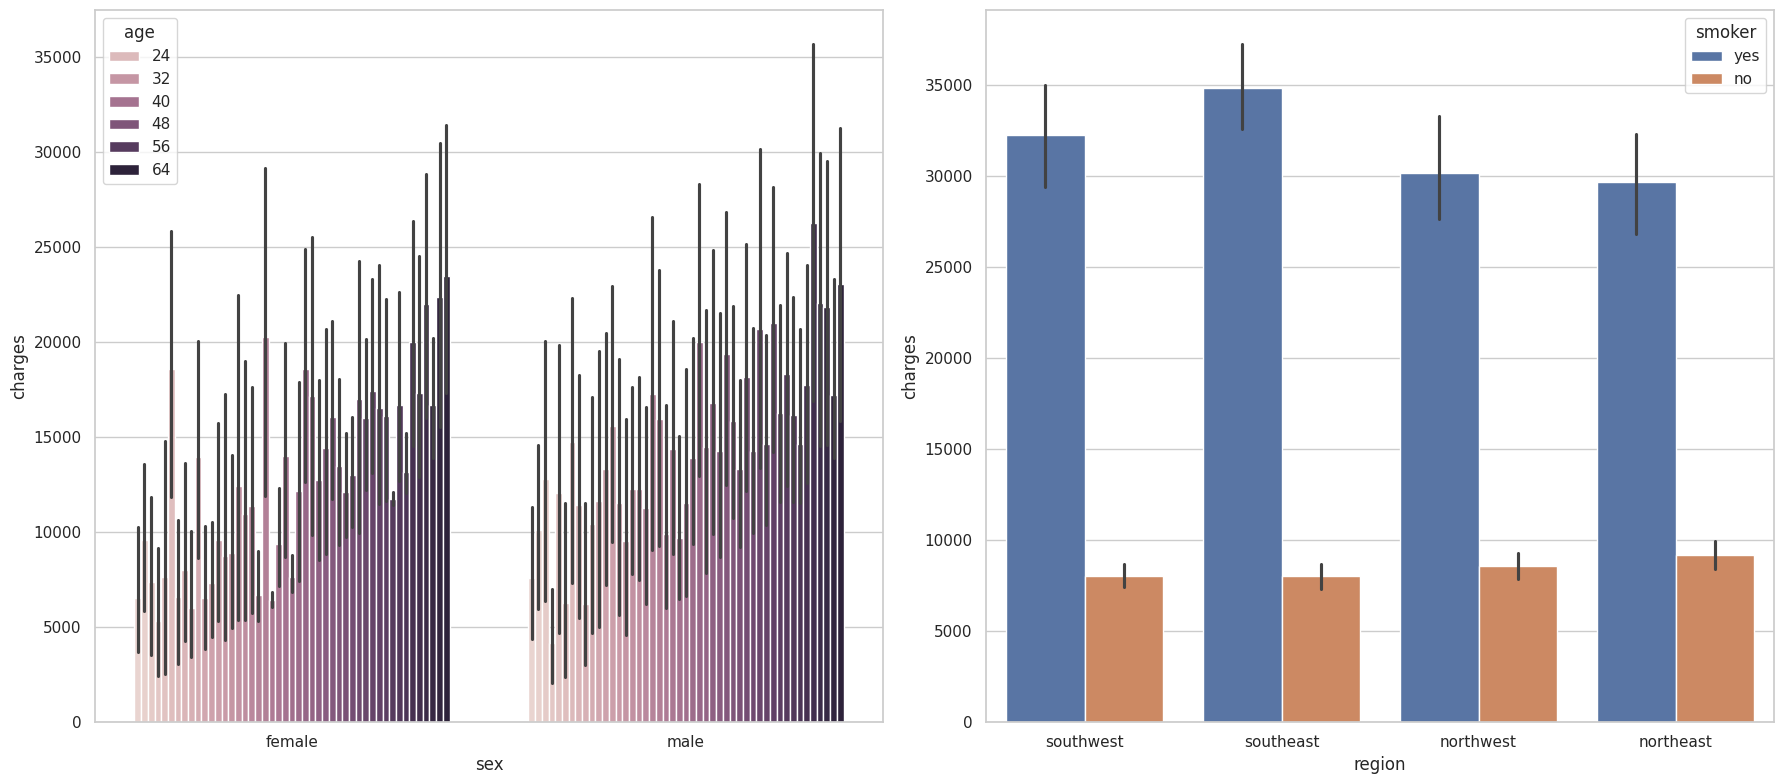

In [164]:
fig, axis = plt.subplots(1, 2, figsize = (18, 8))

sns.barplot(ax = axis[0], data = total_dataf, x = "sex", y = "charges", hue = "age")
sns.barplot(ax = axis[1], data = total_dataf, x = "region", y = "charges", hue = "smoker")

plt.tight_layout()

plt.show()

El análisis bivariante de las variables categóricas muestra que el coste médico varía de forma significativa en función del hábito de fumar, independientemente de la región geográfica. En contraste, las diferencias por sexo son menos pronunciadas y parecen estar condicionadas principalmente por la edad. Estos resultados indican que el hábito de fumar es un factor determinante en el coste médico, mientras que variables como el sexo o la región presentan un impacto más moderado.

## Mapa de Calor

Factorizacion de categoricas

In [165]:
lista_a_factorizar = ["sex", "smoker", "region"]

for var in lista_a_factorizar:
  url_transformado = "../data/processed/" + var + "_transformation_rules.json"
  var_n = var+"_n"

  total_dataf[var_n] = pd.factorize(total_dataf[var])[0]
  total_dataf[[var_n, var]]

  transformation_rules = {row[var]: row[var_n] for index, row in total_dataf[[var_n, var]].drop_duplicates().iterrows()}

  with open(url_transformado, "w") as f:
    json.dump(transformation_rules, f)

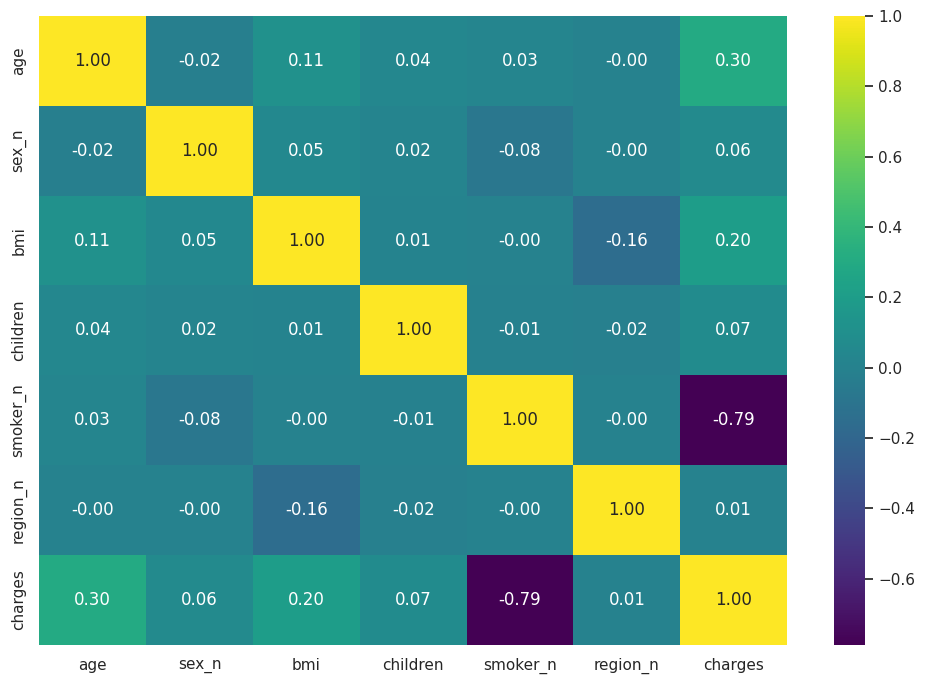

In [166]:

cols_num = ["age", "sex_n", "bmi", "children", "smoker_n", "region_n", "charges"]
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(total_dataf[cols_num].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show() 

El mapa de calor de correlaciones permite analizar de forma global la relación entre las variables numéricas y la variable objetivo. Se observa que el hábito de fumar presenta la correlación positiva más alta con charges, seguido de la edad, mientras que variables como el número de hijos, el sexo o la región muestran una relación débil. Asimismo, no se detectan correlaciones elevadas entre las variables predictoras, lo que sugiere una baja multicolinealidad y un contexto adecuado para la aplicación de modelos de regresión lineal.

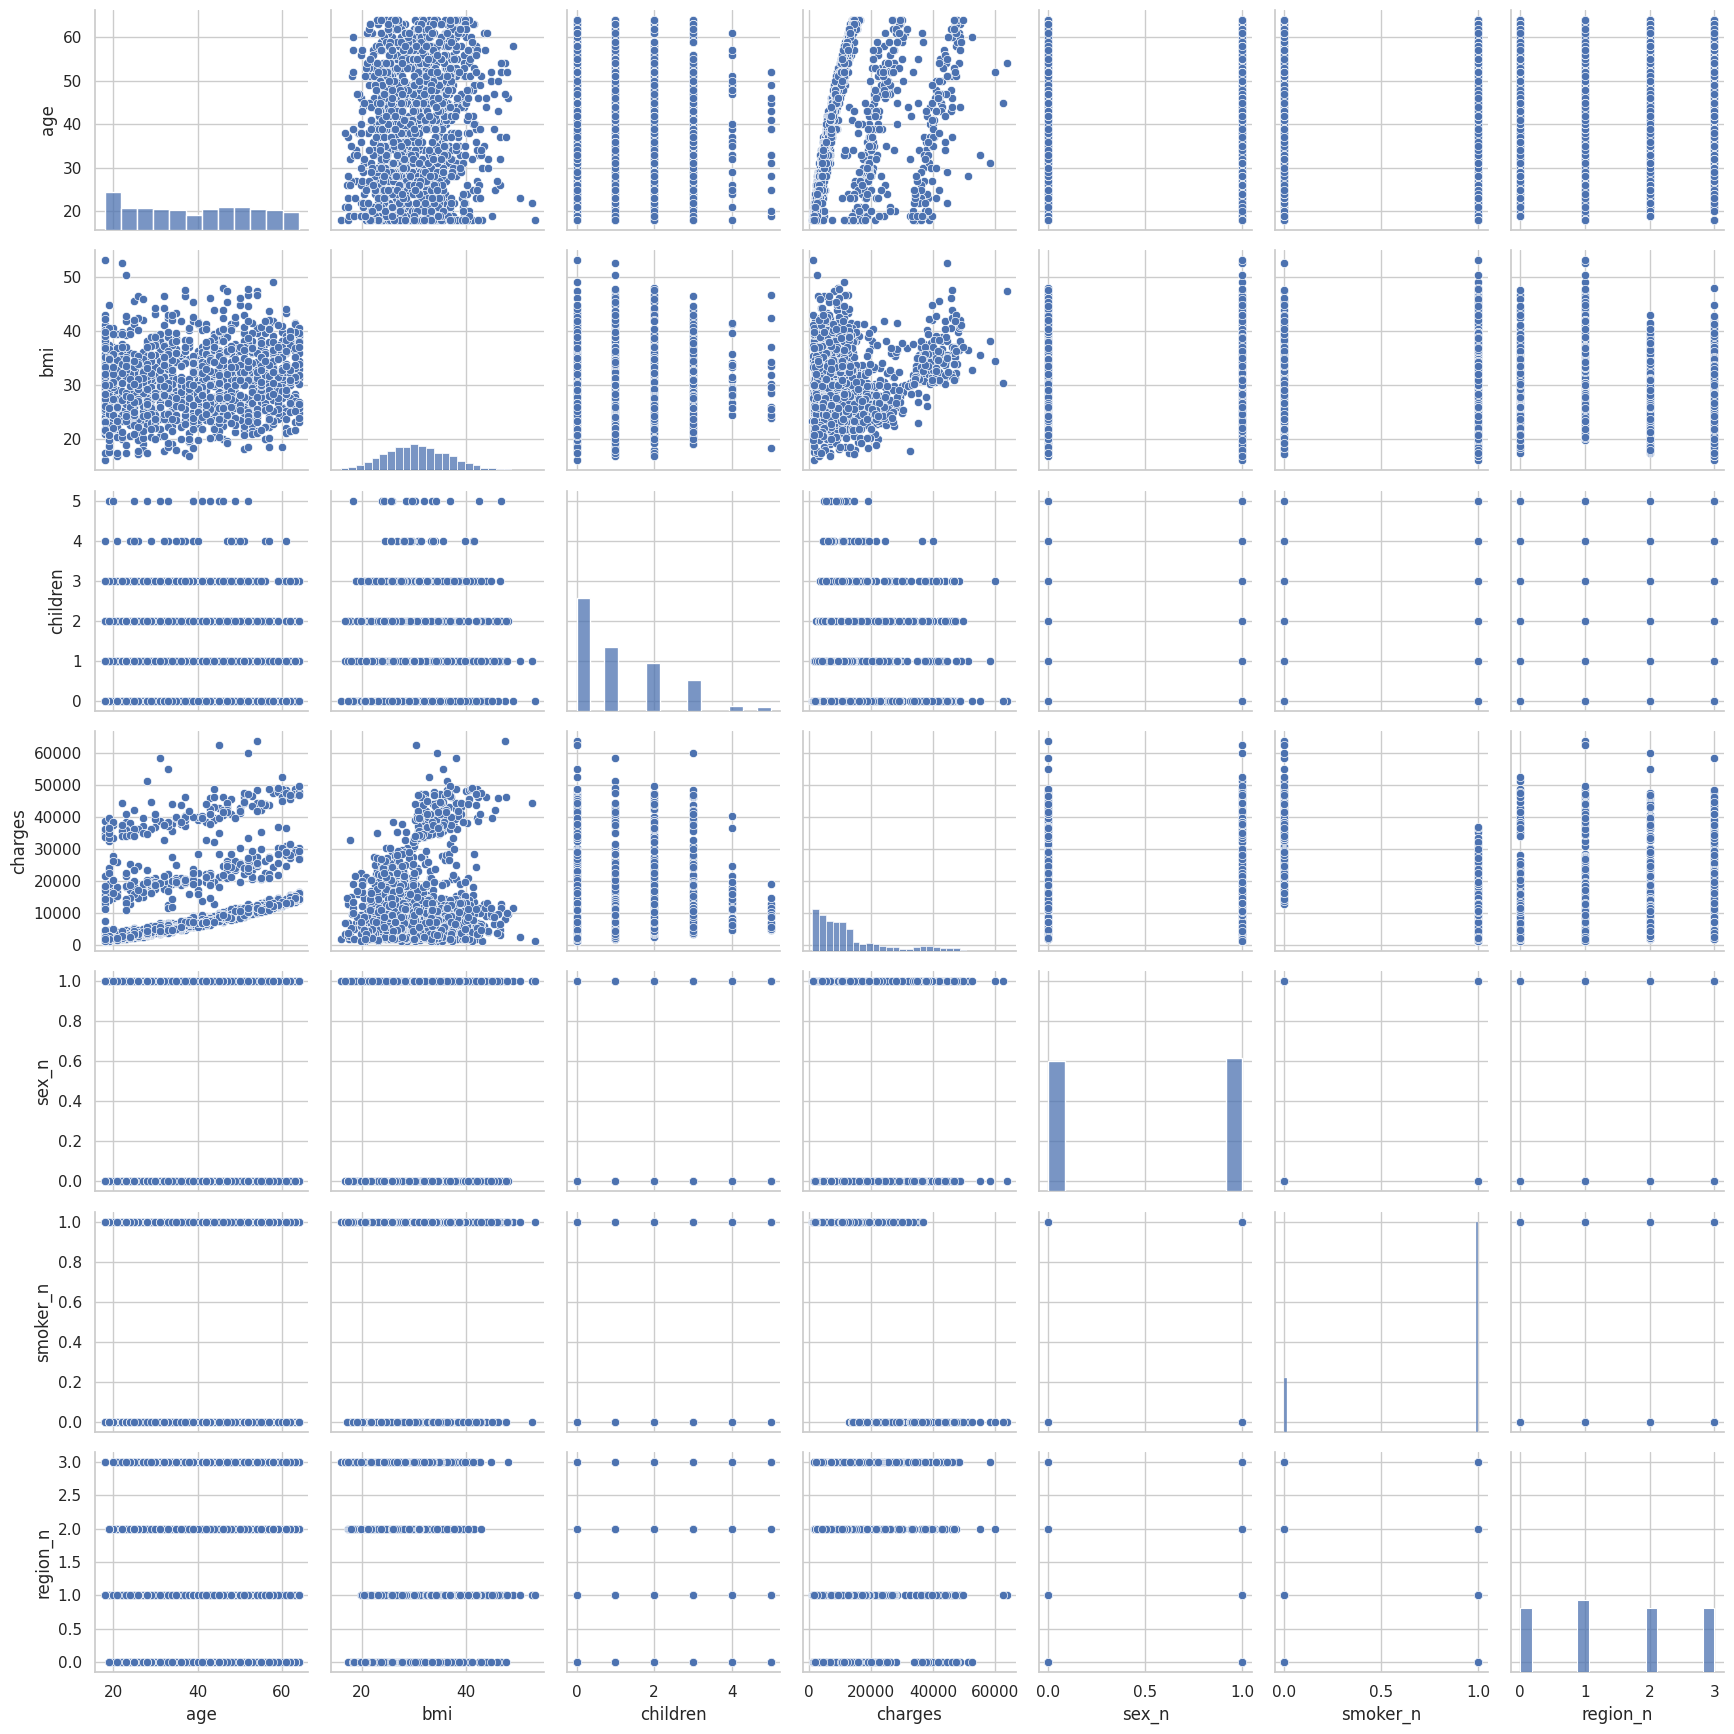

In [167]:
sns.pairplot(data = total_dataf)
plt.tight_layout()
plt.show()

El pairplot permite obtener una visión global de las distribuciones y relaciones entre las variables numéricas del conjunto de datos. A través de este análisis se confirma la ausencia de patrones no lineales evidentes o relaciones inesperadas entre predictores, así como la presencia de asimetría y valores atípicos en la variable objetivo. Este análisis visual refuerza las conclusiones obtenidas previamente y valida la idoneidad del conjunto de datos para su modelado mediante regresión lineal.

EDA TERMINADO

### Feature Engineering

Tratamiento de Outliers

In [168]:

FINAL_COLS = ["age", "sex_n", "bmi", "children", "smoker_n", "region_n", "charges"]
total_dataf = total_dataf[FINAL_COLS]
total_dataf.describe()

,age,sex_n,bmi,children,smoker_n,region_n,charges
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,0.504862,30.663452,1.095737,0.795064,1.483919,13279.121487
std,14.044333,0.500163,6.100468,1.205571,0.403806,1.105208,12110.359656
min,18.000000,0.000000,15.960000,0.000000,0.000000,0.000000,1121.873900
25%,27.000000,0.000000,26.290000,0.000000,1.000000,1.000000,4746.344000
50%,39.000000,1.000000,30.400000,1.000000,1.000000,1.000000,9386.161300
75%,51.000000,1.000000,34.700000,2.000000,1.000000,2.000000,16657.717450
max,64.000000,1.000000,53.130000,5.000000,1.000000,3.000000,63770.428010


A partir del analisis descriptivo de las variables seleccionadas (total_dataf.describe()), se observa que unicamente la variable bmi que esta dando valores mas extremos. Esto suele deberse a un error humano. El resto de variables presenta un rango normal.

In [169]:
# Guardamos todos los datasets:

total_data_CON_outliers = total_dataf.copy()
total_data_SIN_outliers = total_dataf.copy()

outliers_cols = ["bmi"]

def replace_outliers(column, df):
  col_stats = total_dataf[column].describe()
  col_iqr = col_stats["75%"] - col_stats["25%"]
  upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
  lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

  if lower_limit < 0: lower_limit = min(df[column])
  # Vamos a quitar los outliers superiores
  df[column] = df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
  # Vamos a quitar los outliers inferiores
  df[column] = df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
  return df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
  total_data_SIN_outliers, limits = replace_outliers(column, total_data_SIN_outliers)
  outliers_dict.update({column: limits})

with open("../data/processed/outliers_dict.json", "w") as f:
  json.dump(outliers_dict, f)



Escalado de valores

In [170]:
predictoras = ["age", "sex_n", "bmi", "children", "smoker_n", "region_n"]
target = "charges"

X_CON = total_data_CON_outliers.drop(target, axis = 1)[predictoras]
X_SIN = total_data_SIN_outliers.drop(target, axis = 1)[predictoras]
y = total_data_CON_outliers[target]

X_train_CON_outliers, X_test_CON_outliers, y_train, y_test = train_test_split(X_CON, y, test_size = 0.2, random_state = 10)
X_train_SIN_outliers, X_test_SIN_outliers = train_test_split(X_SIN, test_size = 0.2, random_state = 10)

In [171]:
# Normalización

norm_CON_outliers = StandardScaler()

norm_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_norm = norm_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_norm = pd.DataFrame(X_train_CON_outliers_norm, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_norm = norm_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_norm = pd.DataFrame(X_test_CON_outliers_norm, index = X_test_CON_outliers.index, columns = predictoras)

# SIN OUTLIERS
norm_SIN_outliers = StandardScaler()
norm_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_norm = norm_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_norm = pd.DataFrame(X_train_SIN_outliers_norm, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_norm = norm_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_norm = pd.DataFrame(X_test_SIN_outliers_norm, index = X_test_SIN_outliers.index, columns = predictoras)


# ESCALADO MIN-MAX (MINMAXIMIZACIÓN)

scaler_CON_outliers = MinMaxScaler()
scaler_CON_outliers.fit(X_train_CON_outliers)

X_train_CON_outliers_scal = scaler_CON_outliers.transform(X_train_CON_outliers)
X_train_CON_outliers_scal = pd.DataFrame(X_train_CON_outliers_scal, index = X_train_CON_outliers.index, columns = predictoras)

X_test_CON_outliers_scal = scaler_CON_outliers.transform(X_test_CON_outliers)
X_test_CON_outliers_scal = pd.DataFrame(X_test_CON_outliers_scal, index = X_test_CON_outliers.index, columns = predictoras)

# SIN OUTLIERS
scaler_SIN_outliers = MinMaxScaler()
scaler_SIN_outliers.fit(X_train_SIN_outliers)

X_train_SIN_outliers_scal = scaler_SIN_outliers.transform(X_train_SIN_outliers)
X_train_SIN_outliers_scal = pd.DataFrame(X_train_SIN_outliers_scal, index = X_train_SIN_outliers.index, columns = predictoras)

X_test_SIN_outliers_scal = scaler_SIN_outliers.transform(X_test_SIN_outliers)
X_test_SIN_outliers_scal = pd.DataFrame(X_test_SIN_outliers_scal, index = X_test_SIN_outliers.index, columns = predictoras)


# Guardado de los datasets resultantes
X_train_CON_outliers.to_csv("../data/processed/X_train_CON_outliers.xlsx", index = False)
X_train_CON_outliers_norm.to_csv("../data/processed/X_train_CON_outliers_norm.xlsx", index = False)
X_train_CON_outliers_scal.to_csv("../data/processed/X_train_CON_outliers_scal.xlsx", index = False)
X_train_SIN_outliers.to_csv("../data/processed/X_train_SIN_outliers.xlsx", index = False)
X_train_SIN_outliers_norm.to_csv("../data/processed/X_train_SIN_outliers_norm.xlsx", index = False)
X_train_SIN_outliers_scal.to_csv("../data/processed/X_train_SIN_outliers_scal.xlsx", index = False)

X_test_CON_outliers.to_csv("../data/processed/X_test_CON_outliers.xlsx", index = False)
X_test_CON_outliers_norm.to_csv("../data/processed/X_test_CON_outliers_norm.xlsx", index = False)
X_test_CON_outliers_scal.to_csv("../data/processed/X_test_CON_outliers_scal.xlsx", index = False)
X_test_SIN_outliers.to_csv("../data/processed/X_test_SIN_outliers.xlsx", index = False)
X_test_SIN_outliers_norm.to_csv("../data/processed/X_test_SIN_outliers_norm.xlsx", index = False)
X_test_SIN_outliers_scal.to_csv("../data/processed/X_test_SIN_outliers_scal.xlsx", index = False)

y_train.to_csv("../data/processed/y_train.xlsx", index = False)
y_test.to_csv("../data/processed/y_test.xlsx", index = False)

# SCALERS

with open("../models/norm_CON_outliers.pkl", "wb") as file:
  pickle.dump(norm_CON_outliers, file)
with open("../models/norm_SIN_outliers.pkl", "wb") as file:
  pickle.dump(norm_SIN_outliers, file)
with open("../models/scaler_CON_outliers.pkl", "wb") as file:
  pickle.dump(scaler_CON_outliers, file)
with open("../models/scaler_SIN_outliers.pkl", "wb") as file:
  pickle.dump(scaler_SIN_outliers, file)



In [172]:
X_train = X_train_CON_outliers.copy()
X_test = X_test_CON_outliers.copy()

selection_model = SelectKBest(f_classif, k = 5)
selection_model.fit(X_train, y_train)

ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

X_train_sel.head()

/home/vscode/.local/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:107: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)


,sex_n,bmi,children,smoker_n,region_n
0,1.0,25.90,3.0,0.0,0.0
1,0.0,32.34,1.0,1.0,1.0
2,1.0,34.10,0.0,1.0,1.0
3,1.0,37.10,1.0,1.0,0.0
4,0.0,25.30,1.0,1.0,0.0
